# TCGA dataset overview

In [1]:
library(dplyr)
library(ggplot2)
library(ggpubr)
library(ggsci)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Load data

In [2]:
load("../input/tcga.metadata.RData",verbose = T)
stage.cancers<-read.table("../input/cancers_valid_stage.tsv")$V1
condition.cancers<-read.table("../input/cancers_valid_condition.tsv")$V1

Loading objects:
  metadata


In [3]:
head(metadata)

,file_id,submitter_id,patient_id,cancer,is_outlier.lof,condition,gender,age_at_index,stage,ESTIMATEScore,impurity,purity
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,0363945b-657c-4001-8b6d-4533c49394cc,TCGA-PA-A5YG-01A,TCGA-PA-A5YG,ACC,FALSE,tumor,male,51,2,42147.61,0.41332223,0.5866778
2,06ebee53-f158-49d7-baf2-6910780f023b,TCGA-OR-A5K8-01A,TCGA-OR-A5K8,ACC,FALSE,tumor,male,39,2,35724.89,0.17504081,0.8249592
3,0820ab39-407d-4326-8482-9c0c0fcc66f6,TCGA-OR-A5LT-01A,TCGA-OR-A5LT,ACC,FALSE,tumor,male,57,3,33944.49,0.12508489,0.8749151
4,084af283-eb9b-4327-add2-04227e78aff9,TCGA-PK-A5HB-01A,TCGA-PK-A5HB,ACC,FALSE,tumor,male,63,0,35084.28,0.15618170,0.8438183
5,0cbbae7f-c50f-43ed-8b3e-da334238a5bb,TCGA-OR-A5KV-01A,TCGA-OR-A5KV,ACC,FALSE,tumor,female,17,3,32693.27,0.09468693,0.9053131
6,0ecde3de-4840-4090-9041-201e9d8bd162,TCGA-OR-A5L9-01A,TCGA-OR-A5L9,ACC,FALSE,tumor,female,53,2,40437.02,0.34185617,0.6581438


In [4]:
message("Total number of samples ",length(unique(metadata$file_id)))

Total number of samples 10191



### Process data

In [5]:
model.mt<-data.frame(cancer = unique(metadata$cancer)) %>%
          mutate(Stage = cancer %in% stage.cancers,
                 T_vs_N = cancer %in% condition.cancers) %>%
          group_by(cancer) %>%
          tidyr::pivot_longer(cols = Stage:T_vs_N,names_to = "name") %>% ungroup()
model.mt<-model.mt %>%
          full_join(.,model.mt %>% tidyr::expand(cancer,name))  %>%
          mutate(value = ifelse(is.na(value),FALSE,value)) %>%
          mutate(cancer=factor(cancer,levels=c("SKCM","UVM","SARC","PRAD","TGCT",
                                                "OV","UCS","UCEC","CESC","LAML",
                                                "READ","BLCA","COAD","PAAD","CHOL",
                                               "KIRP","KIRC","KICH","ACC","PCPG",
                                               "STAD","LIHC","MESO","LUSC","LUAD",
                                               "BRCA","DLBC","THYM","THCA","ESCA",
                                               "HNSC","GBM","LGG")))

Joining, by = c("cancer", "name")


In [6]:
mt<-metadata %>%
    group_by(cancer) %>%
    summarize(Total=length(unique(file_id)),
              Tumor=sum(condition=="tumor" & !is_outlier.lof,na.rm=T),
              Outliers=sum(condition=="tumor" & is_outlier.lof,na.rm=T),
              Normal=sum(condition=="normal" & !is_outlier.lof,na.rm=T),
              Stage0=sum(stage==0),
              Stage1=sum(stage==1),
              Stage2=sum(stage==2),
              Stage3=sum(stage==3),
              Stage4=sum(stage==4)) %>%
    tidyr::pivot_longer(cols = Total:Stage4) %>%
    mutate(cancer=factor(cancer,levels=c("SKCM","UVM","SARC","PRAD","TGCT",
                                                "OV","UCS","UCEC","CESC","LAML",
                                                "READ","BLCA","COAD","PAAD","CHOL",
                                               "KIRP","KIRC","KICH","ACC","PCPG",
                                               "STAD","LIHC","MESO","LUSC","LUAD",
                                               "BRCA","DLBC","THYM","THCA","ESCA",
                                               "HNSC","GBM","LGG")),
          name=factor(name,levels=c("Total","Tumor","Normal","Outliers","Stage0","Stage1","Stage2","Stage3","Stage4")))

### Visualizations

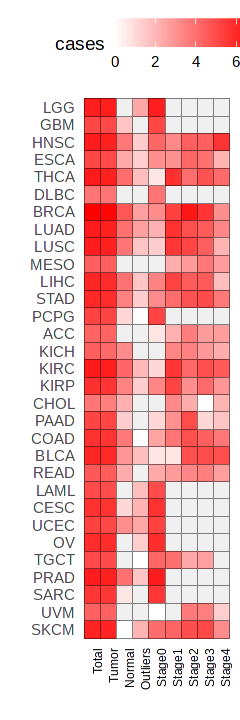

In [7]:
options(repr.plot.width=2,repr.plot.height=6)
col.pal <- colorRampPalette(colors = c("#ffffff","#FF0000"))
p<-ggplot(mt,aes(x=cancer,y=name,fill=log(value)))+
    geom_tile(color="black")+
    scale_fill_gradientn(colours = col.pal(10),na.value = "#f0f0f0",)+
    theme(legend.position = "top",
          axis.text.x = element_text(size=7,color="black",angle=90,hjust=1),
          panel.background = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          axis.ticks = element_blank())+
    coord_flip()+
    labs(fill="cases",x="",y="")
p

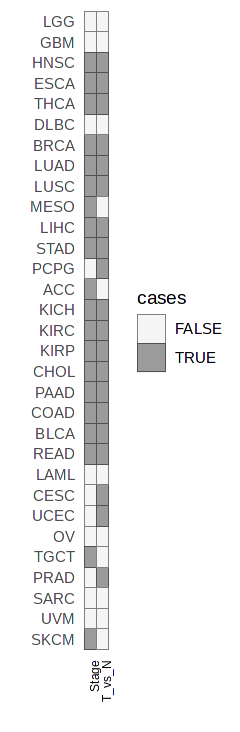

In [8]:
options(repr.plot.width=2,repr.plot.height=6.1)
p<-ggplot(model.mt,aes(x=cancer,y=name,fill=value))+
    geom_tile(color="black")+
    scale_fill_manual(values=c("#F5F5F5","#9B9B9B"))+
    theme(legend.position = "right",
          axis.text.x = element_text(size=7,color="black",angle=90,hjust=1),
          panel.background = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          axis.ticks = element_blank())+
    coord_flip()+
    labs(fill="cases",x="",y="")
p

### Number of samples

In [9]:
stage_cancers<-model.mt %>% 
                filter(name=="Stage",value) %>%
                distinct(cancer) %>% 
                unlist() %>%
                as.character()
condition_cancers<-model.mt %>% 
                filter(name=="T_vs_N",value) %>%
                distinct(cancer) %>% 
                unlist() %>%
                as.character()

In [10]:
metadata %>%
filter(cancer %in% stage_cancers,
       !is_outlier.lof) %>%
group_by(condition)%>%
summarize(n=length(file_id))

condition,n
<chr>,<int>
normal,616
tumor,6621


In [11]:
metadata %>%
filter(cancer %in% condition_cancers | cancer %in% stage_cancers) %>%
group_by(condition)%>%
summarize(n=length(file_id))

condition,n
<chr>,<int>
normal,708
tumor,7871
